In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd

pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
df_transactions = pd.read_csv(
    "../data/transactions_no_outliers.csv", parse_dates=["date"]
)

<IPython.core.display.Javascript object>

In [8]:
def _resample_per_week_unique_account(df: pd.DataFrame) -> pd.DataFrame:
    """Resample date into weeks for a unique account."""
    account_id = df["account_id"].iloc[0]

    temporary_df = df[df["account_id"] == account_id].sort_values(
        by="date", ascending=True
    )[["date", "amount"]]

    temporary_df = temporary_df.set_index("date", drop=True)

    temporary_df = temporary_df.resample("W-MON").sum().reset_index()
    temporary_df["account_id"] = account_id

    return temporary_df


def get_new_resample_expenses_df(df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with resampled data into weeks and keep only expenses."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _resample_per_week_unique_account(
                df=df_unique_account,
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [13]:
resampled_transactions = get_new_resample_expenses_df(df=df_transactions)

<IPython.core.display.Javascript object>

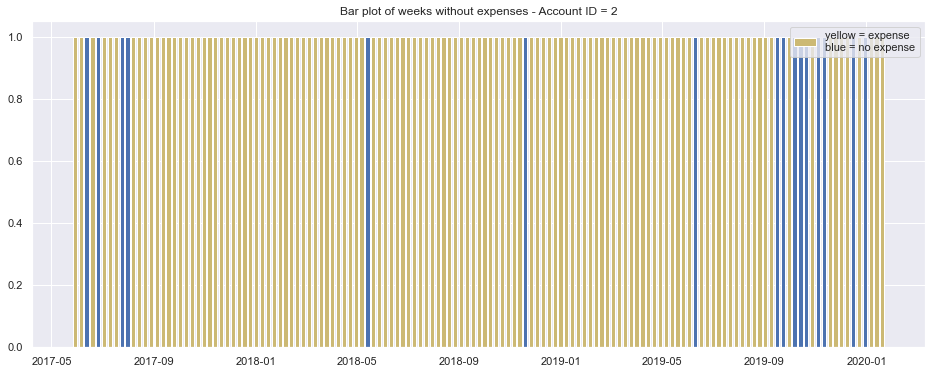

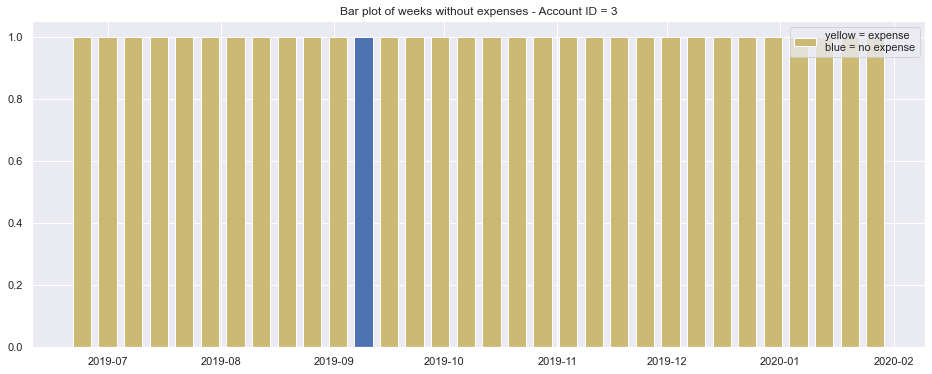

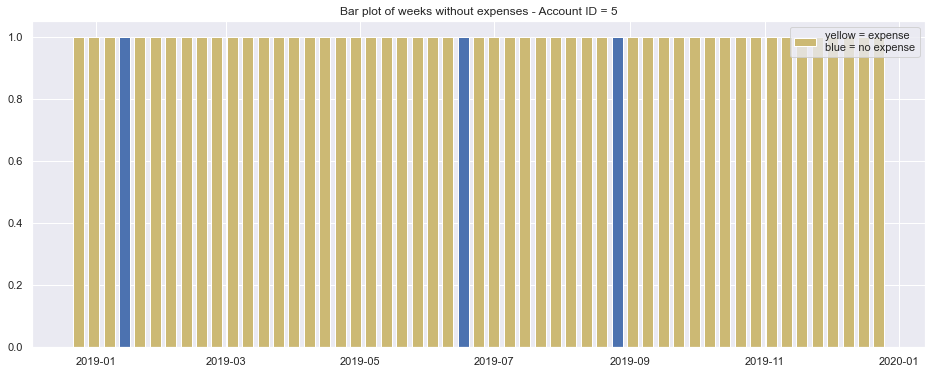

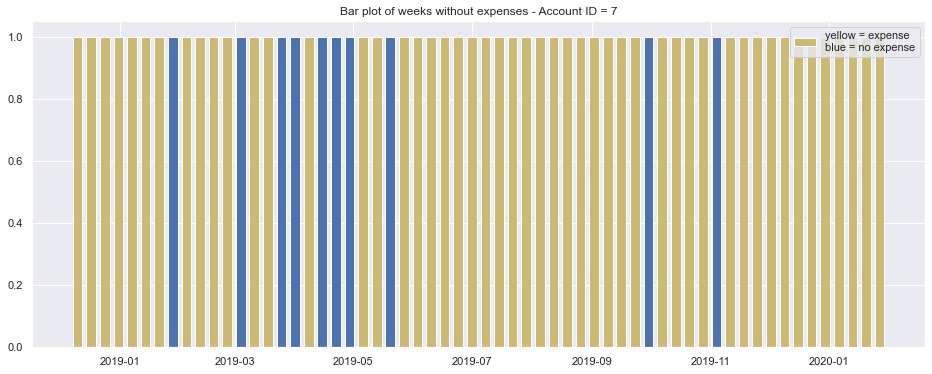

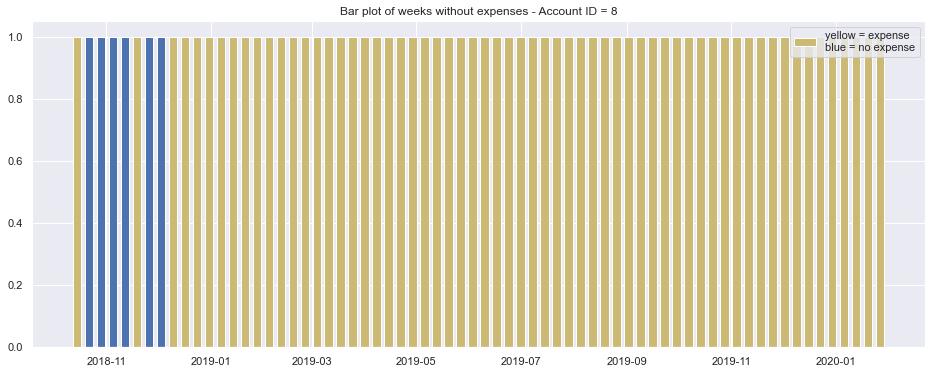

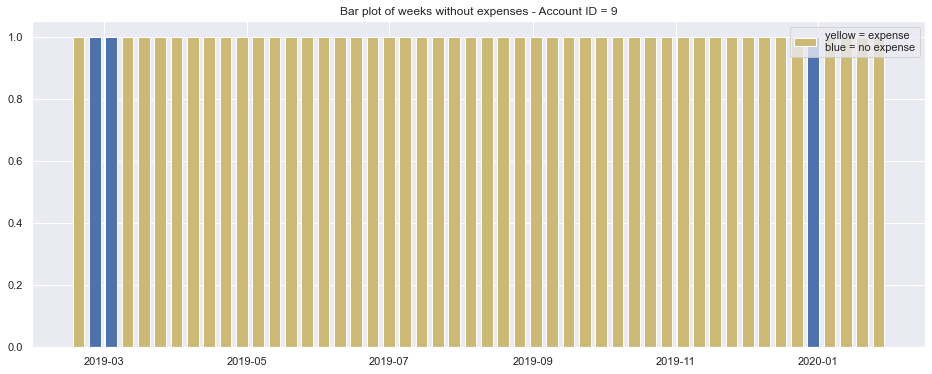

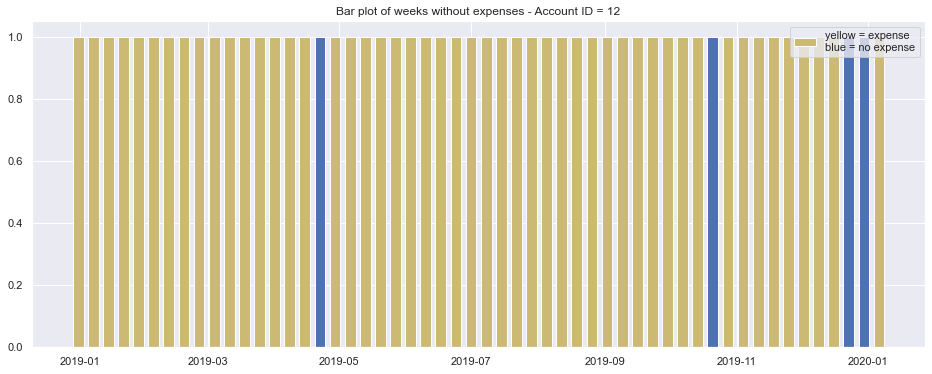

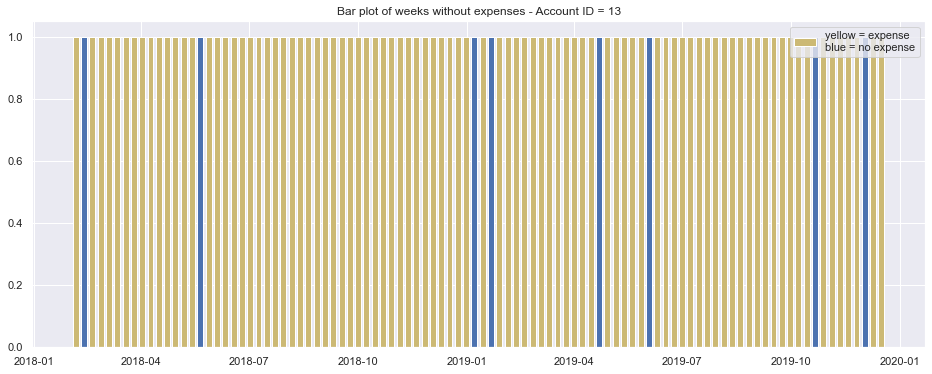

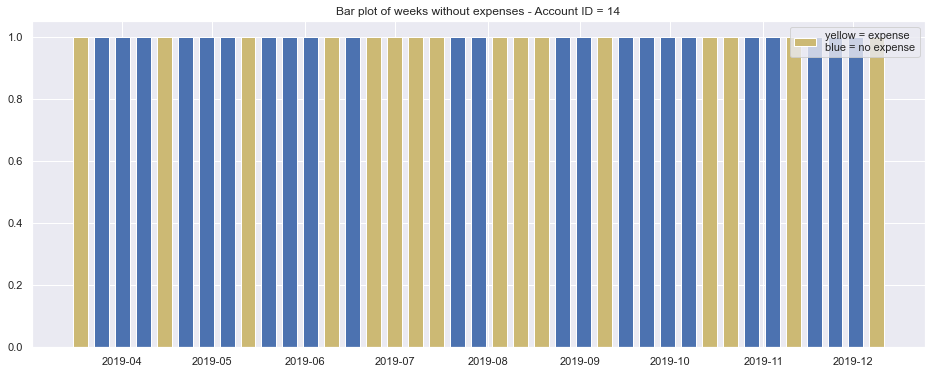

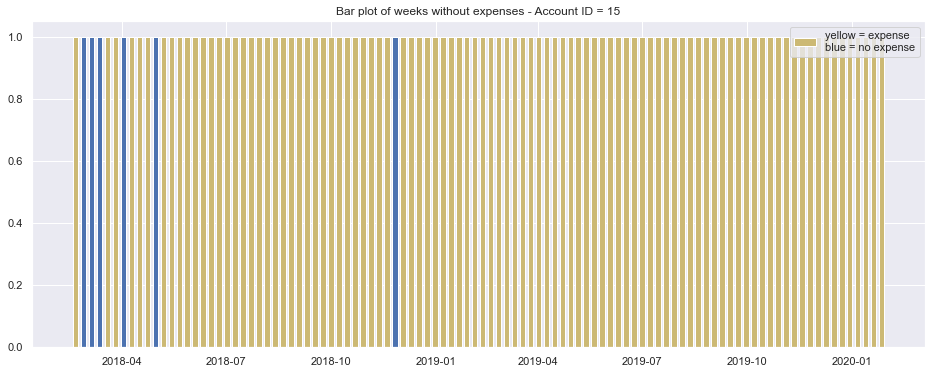

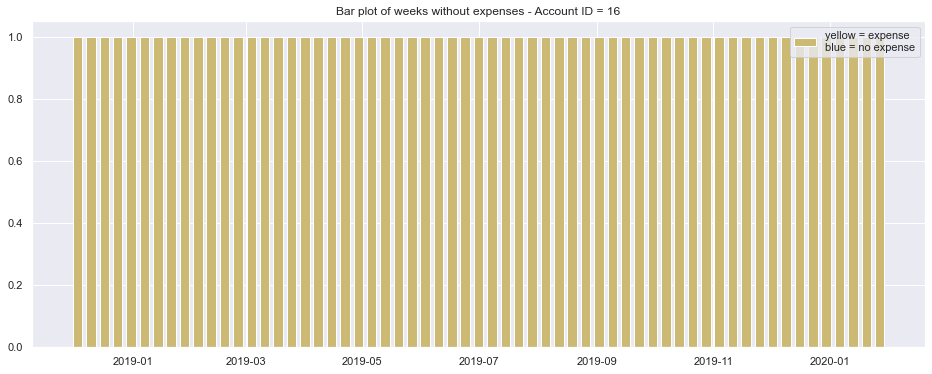

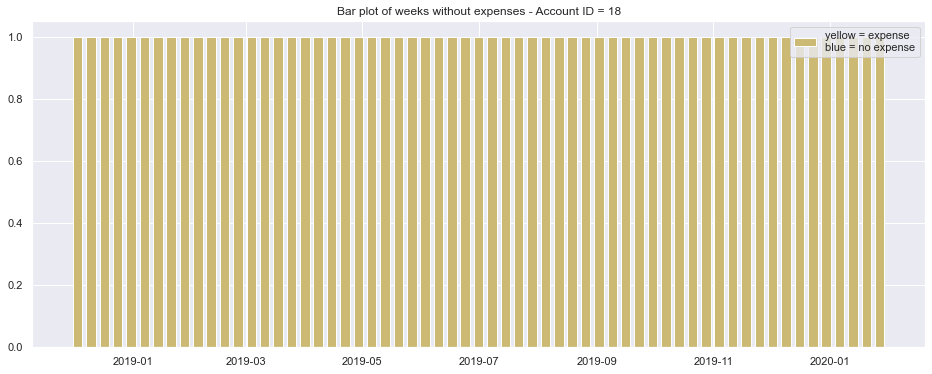

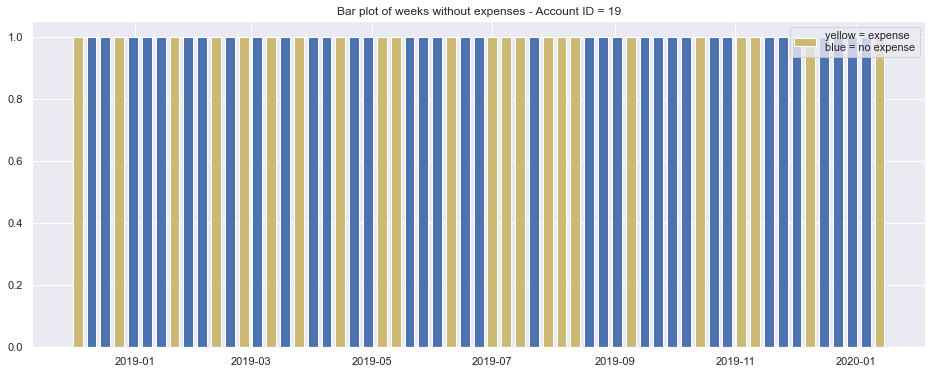

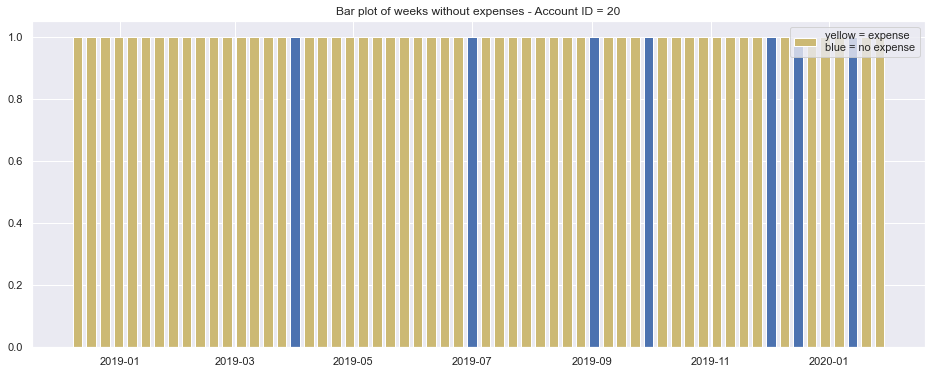

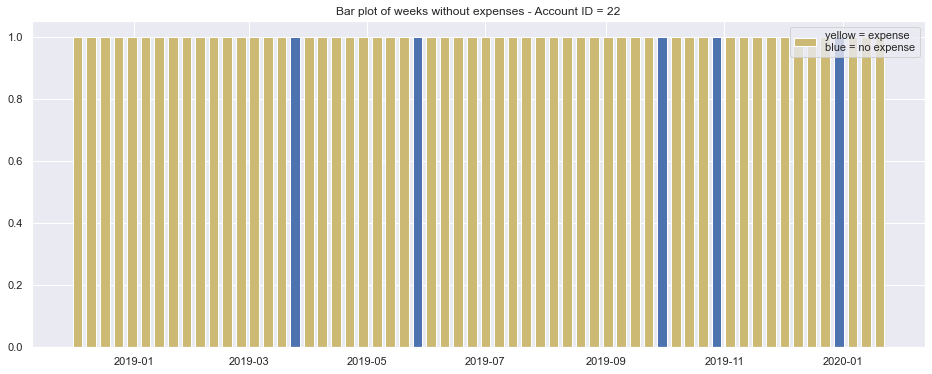

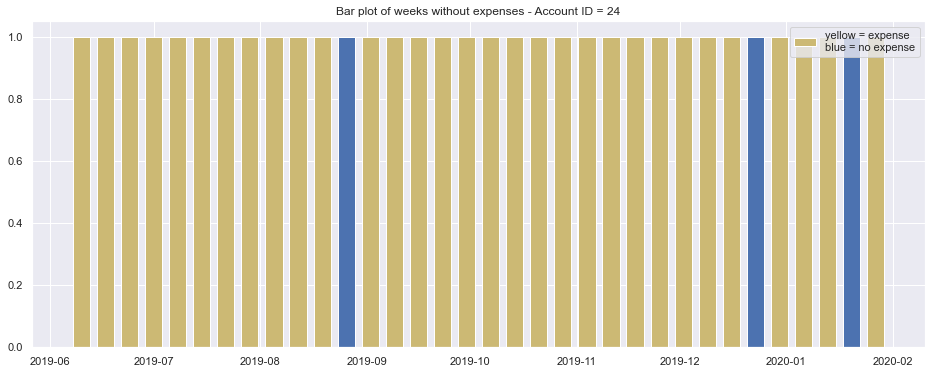

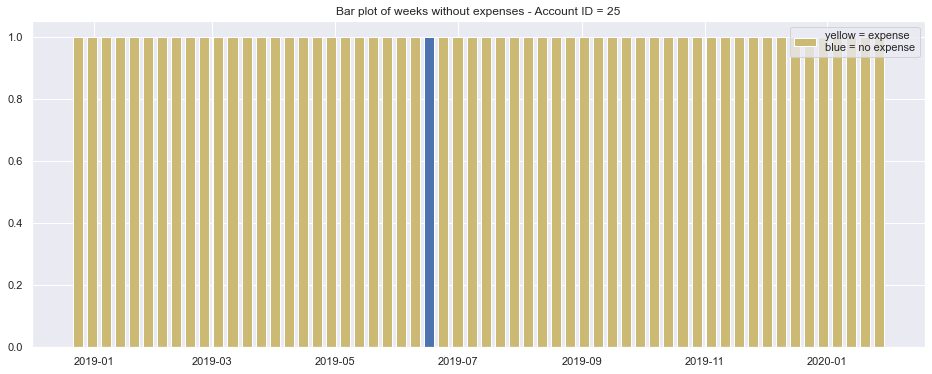

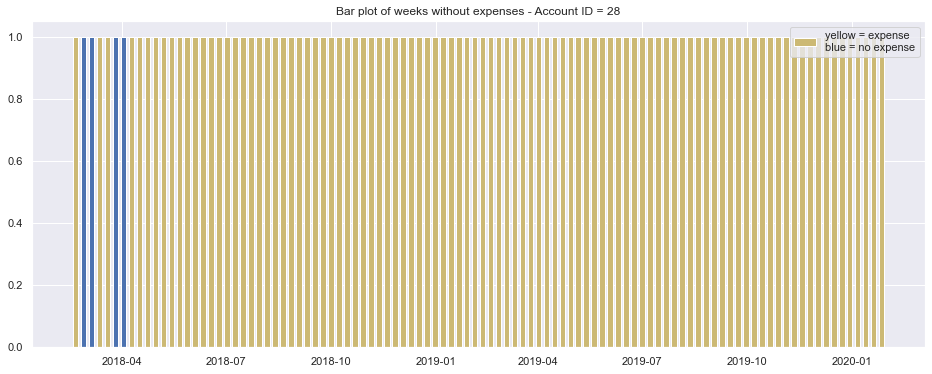

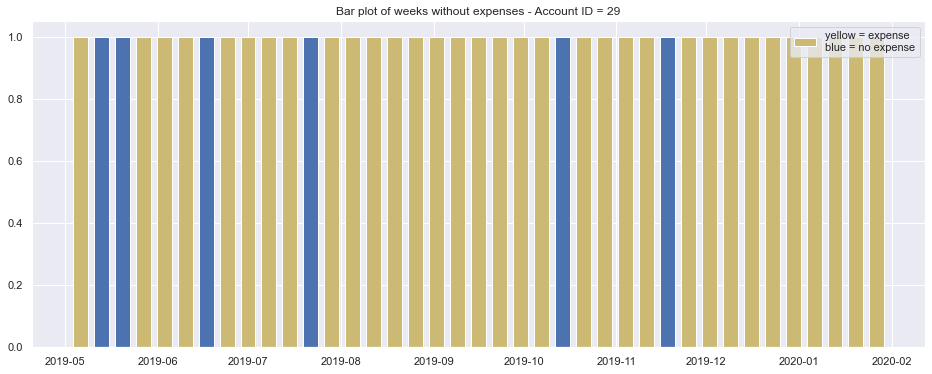

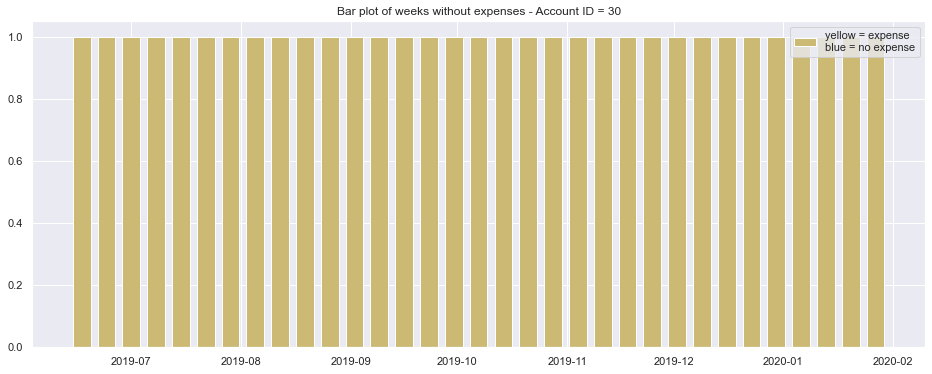

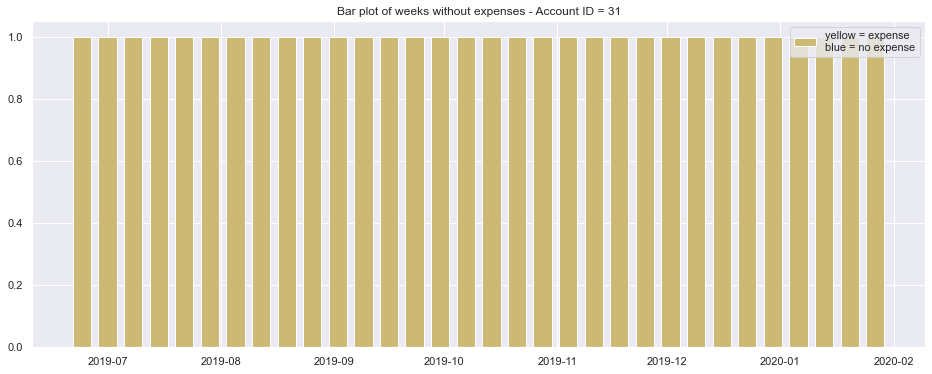

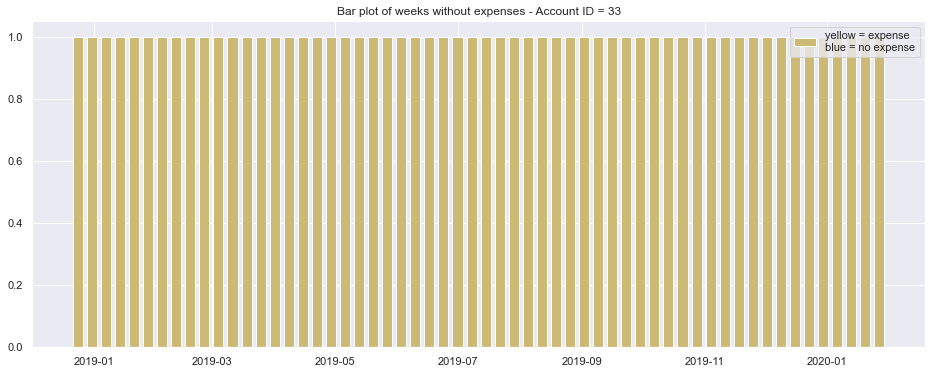

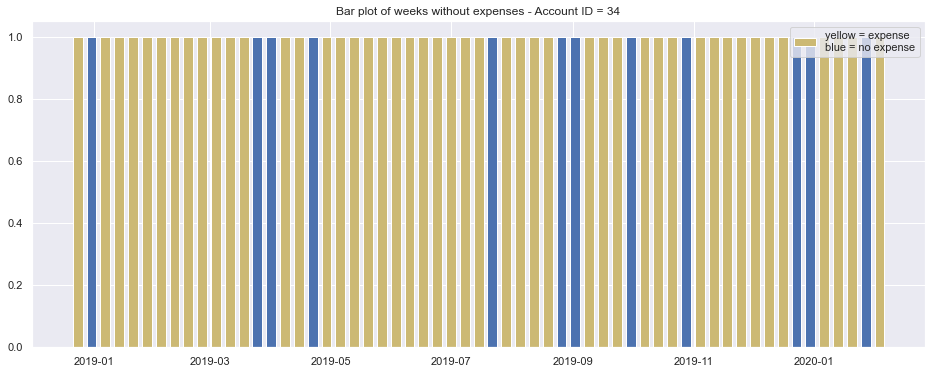

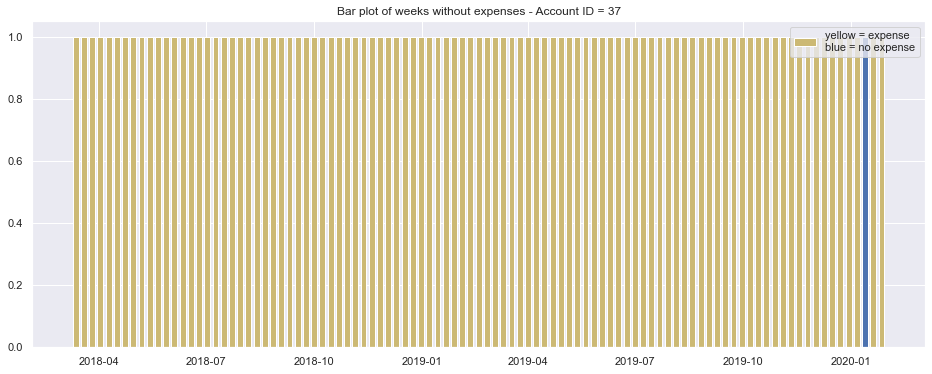

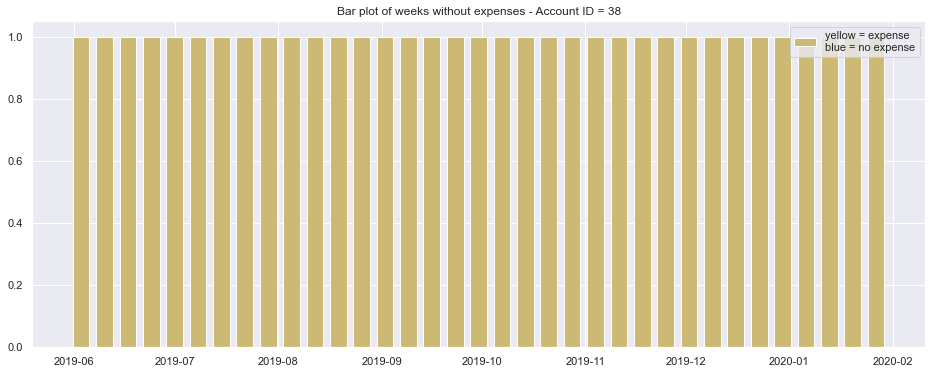

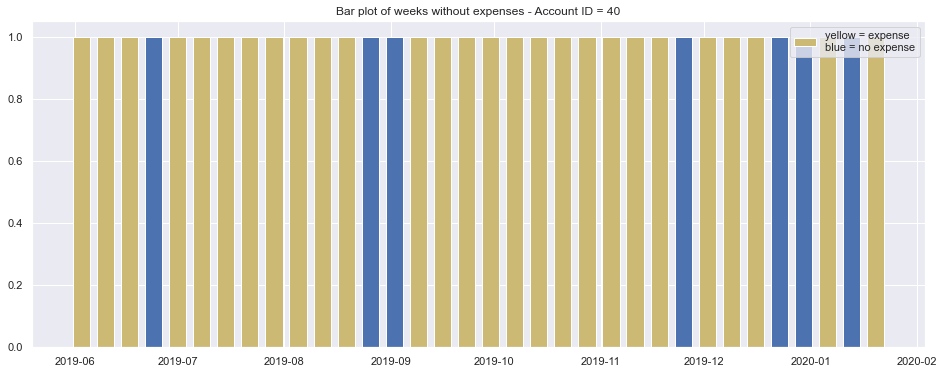

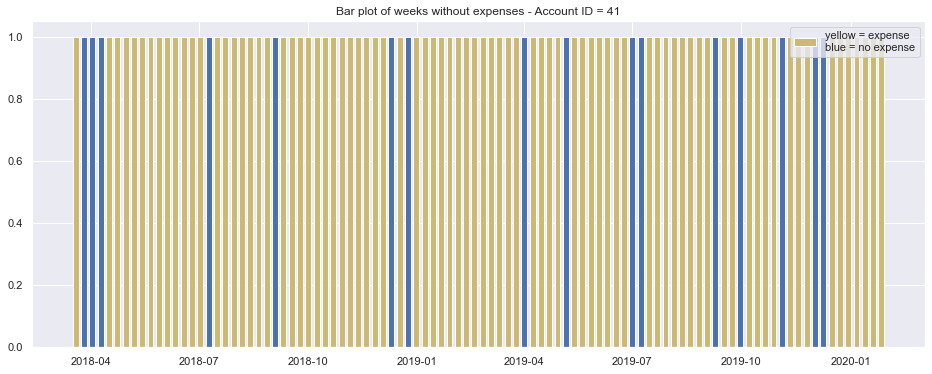

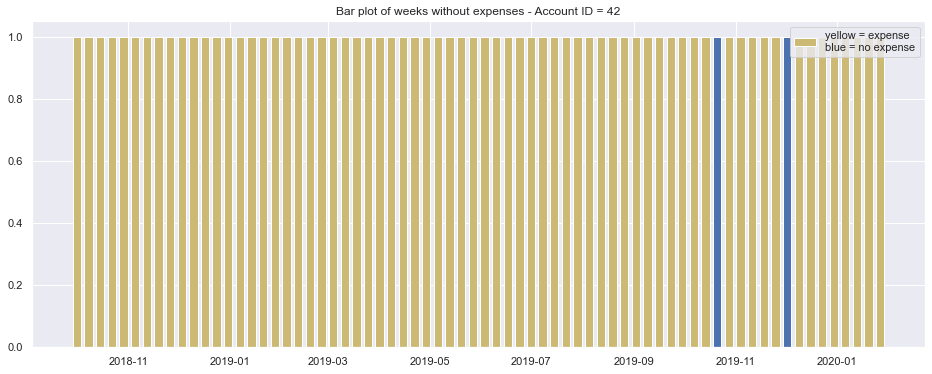

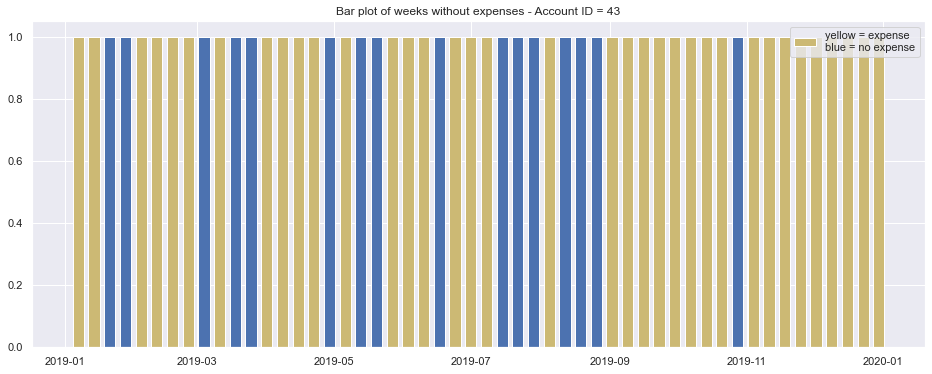

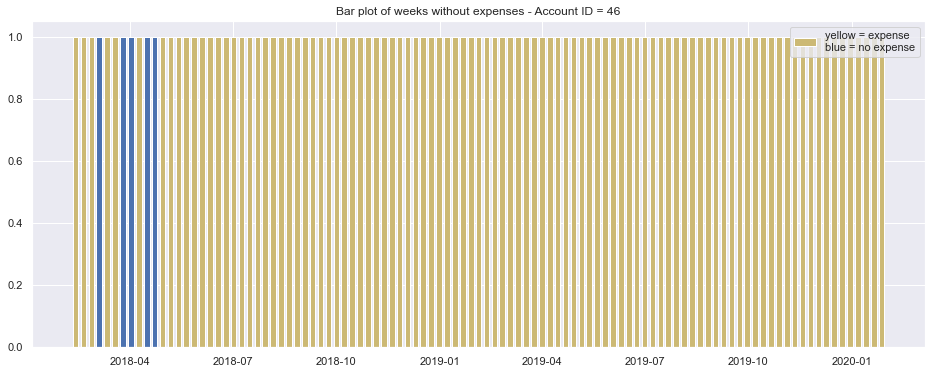

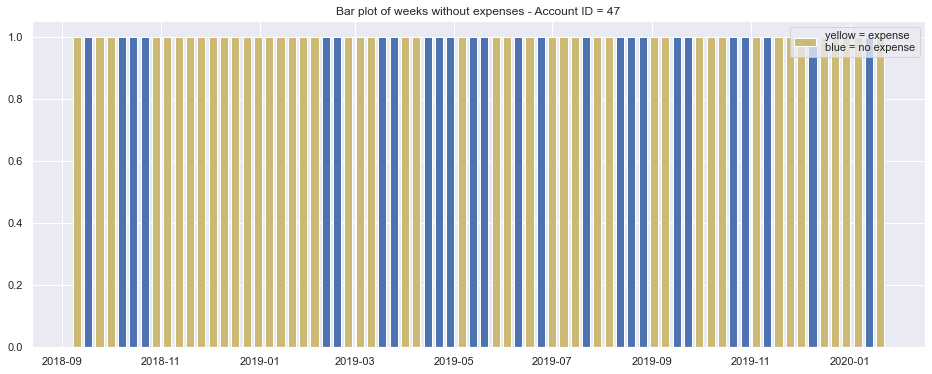

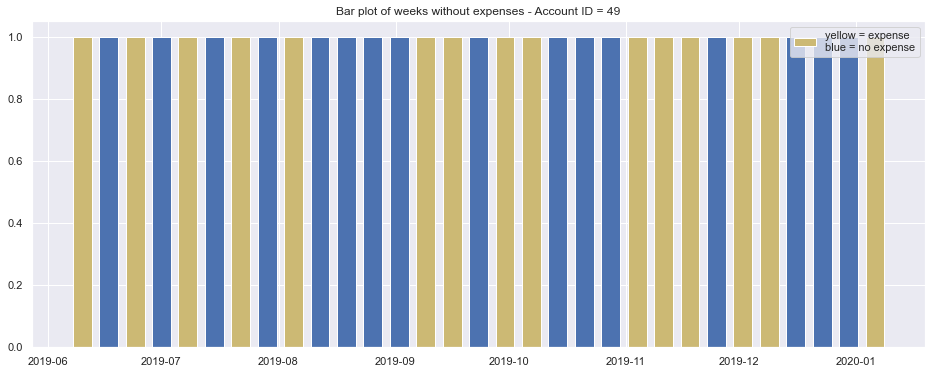

<IPython.core.display.Javascript object>

In [12]:
for account_id in resampled_trasactions["account_id"].unique():
    plt.figure(figsize=(16, 6))
    temp_df = resampled_transactions[resampled_transactions["account_id"] == account_id]
    mask_no_expenses = temp_df["amount"] == 0
    plt.bar(
        temp_df["date"],
        np.ones(len(mask_no_expenses)),
        color=[["y", "b"][idx] for idx in mask_no_expenses],
        width=5,
        label="yellow = expense\nblue = no expense",
    )
    plt.title(
        f"Bar plot of weeks without expenses - Account ID = {account_id}", fontsize=12
    )
    plt.legend()

Some `periods of transactions` need to be removed before training due to lack to data.

Concerning this step, I feel like having more insights about the business might help me. Where the transactions come from ? Is it `ok` to have that much weeks with no data ?

- Concerning accounts that have a lot of empty weeks, I don't see any seasonality in the way data is missing.

Hence I will consider that at each window of 12 weeks, if i have >= weeks without data than with, the window is an outlier.

In [14]:
def _remove_outliers_windows_unique_account(
    df: pd.DataFrame, max_empty_weeks: int
) -> pd.DataFrame:
    """Removes windows that have more than `max_empty_weeks` empty weeks for a unique account."""
    for i in range(1, 13):
        df[f"previous_amount_{i}"] = df["amount"].shift(i, fill_value=0)
    return df[(df == 0).sum(1) < max_empty_weeks]


def remove_outliers_windows(df: pd.DataFrame, max_empty_weeks: int) -> pd.DataFrame:
    """Removes windows that have more than `max_empty_weeks` empty weeks."""
    transactions_dfs = [data for _, data in df.groupby("account_id")]

    return pd.concat(
        [
            _remove_outliers_windows_unique_account(
                df=df_unique_account, max_empty_weeks=max_empty_weeks
            )
            for df_unique_account in transactions_dfs
        ]
    ).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [16]:
df_no_empty_windows = remove_outliers_windows(
    df=resampled_transactions, max_empty_weeks=6
)

<IPython.core.display.Javascript object>

Now that we removed windows with vmany empty weeks, here the final dataset, where each row is a window that can be used for either training or evaluation.

In [24]:
df_no_empty_windows

,date,amount,account_id,previous_amount_1,previous_amount_2,previous_amount_3,previous_amount_4,previous_amount_5,previous_amount_6,previous_amount_7,previous_amount_8,previous_amount_9,previous_amount_10,previous_amount_11,previous_amount_12
0,2017-08-14,180.00,2,11.94,0.00,0.00,5.90,13.26,203.52,0.00,5.90,0.00,2293.69,5.90,0.00
1,2017-08-21,375.90,2,180.00,11.94,0.00,0.00,5.90,13.26,203.52,0.00,5.90,0.00,2293.69,5.90
2,2017-08-28,281.74,2,375.90,180.00,11.94,0.00,0.00,5.90,13.26,203.52,0.00,5.90,0.00,2293.69
3,2017-09-04,1339.20,2,281.74,375.90,180.00,11.94,0.00,0.00,5.90,13.26,203.52,0.00,5.90,0.00
4,2017-09-11,2520.28,2,1339.20,281.74,375.90,180.00,11.94,0.00,0.00,5.90,13.26,203.52,0.00,5.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,2020-01-06,1120.80,47,1139.60,758.80,500.00,0.00,1782.18,720.50,74.00,0.00,215.60,0.00,0.00,767.50
1569,2020-01-13,0.00,47,1120.80,1139.60,758.80,500.00,0.00,1782.18,720.50,74.00,0.00,215.60,0.00,0.00
1570,2020-01-20,37.00,47,0.00,1120.80,1139.60,758.80,500.00,0.00,1782.18,720.50,74.00,0.00,215.60,0.00
1571,2019-12-02,60.00,49,0.00,500.00,100.00,10.80,0.00,0.00,0.00,422.80,1500.00,0.00,1850.00,10.80


<IPython.core.display.Javascript object>

<AxesSubplot:>

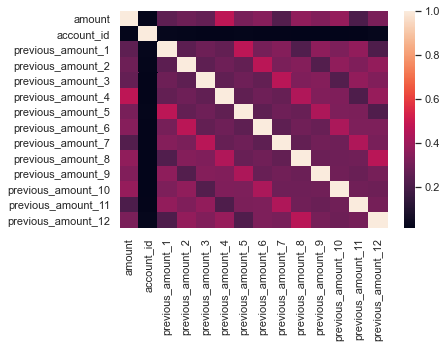

<IPython.core.display.Javascript object>

In [23]:
# calculate the correlation matrix
corr = df_no_empty_windows.corr()

# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

We observe that the most correlated column to the `amount` one is the expense of week - 4, which represents the same week in the previous month. 

In [25]:
# Save final data set
df_no_empty_windows.to_csv("../data/transactions_final_set.csv", index=False)

<IPython.core.display.Javascript object>